In [13]:
main_dir = '/Users/simon/bsose_monthly/'
salt = main_dir + 'bsose_i106_2008to2012_monthly_Salt.nc'
theta = main_dir + 'bsose_i106_2008to2012_monthly_Theta.nc'

%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import os, sys
sys.path.insert(0, os.path.abspath('..'))

import pyxpcm
from pyxpcm.models import pcm


def pcm_fit_and_post(time_i=42, K=4, maxvar=2):  
    # Define features to use
    # Instantiate the PCM
    
    max_depth = 2000
    z = np.arange(0., -max_depth, -10.)
    features_pcm = {'THETA': z, 'SALT': z}
    features = {'THETA': 'THETA', 'SALT': 'SALT'}
    salt_nc = xr.open_dataset(salt).isel(time=time_i)
    theta_nc = xr.open_dataset(theta).isel(time=time_i)
    big_nc = xr.merge([salt_nc, theta_nc])
    both_nc = big_nc.where(big_nc.coords['Depth'] > 
                           max_depth).drop(['iter', 'Depth', 
                                            'rA', 'drF', 'hFacC'])   
 
    attr_d = {}

    for coord in both_nc.coords:
        attr_d[coord] = both_nc.coords[coord].attrs
        
    lons_new = np.linspace(both_nc.XC.min(), both_nc.XC.max(), 60*4)
    lats_new = np.linspace(both_nc.YC.min(), both_nc.YC.max(), 60)
    # ds = both_nc # .copy(deep=True)
    ds = both_nc.interp(coords={'YC': lats_new, 'XC': lons_new})#, method='cubic')
        
    m = pcm(K=K, features=features_pcm, 
            maxvar=maxvar, 
            timeit=True, timeit_verb=1, separate_pca=False)
    m.fit(ds, features=features, dim='Z') #, inplace=True)
    m.predict(ds, features=features, dim='Z', inplace=True)
    m.predict_proba(ds, features=features, dim='Z', inplace=True)
    m.find_i_metric(ds, inplace=True)
    
    def sanitize():
        del ds.PCM_LABELS.attrs['_pyXpcm_cleanable']
        del ds.PCM_POST.attrs['_pyXpcm_cleanable']
        del ds.PCM_RANK.attrs['_pyXpcm_cleanable']
        
    for coord in attr_d:
        ds.coords[coord].attrs = attr_d[coord]
    
    sanitize()
    return ds, m

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
ds, m = pcm_fit_and_post(time_i=42, K=4, maxvar=2)
ds

  fit.1-preprocess.1-mask: 14 ms
  fit.1-preprocess.2-feature_THETA.1-ravel: 19 ms
  fit.1-preprocess.2-feature_THETA.2-interp: 25 ms
  fit.1-preprocess.2-feature_THETA.3-scale_fit: 77 ms
  fit.1-preprocess.2-feature_THETA.4-scale_transform: 30 ms
  fit.1-preprocess.2-feature_THETA.total: 153 ms
  fit.1-preprocess.2-feature_SALT.1-ravel: 14 ms
  fit.1-preprocess.2-feature_SALT.2-interp: 17 ms
  fit.1-preprocess.2-feature_SALT.3-scale_fit: 63 ms
  fit.1-preprocess.2-feature_SALT.4-scale_transform: 34 ms
  fit.1-preprocess.2-feature_SALT.total: 131 ms
  fit.1-preprocess.2-feature_all.5-join: 16 ms
Fitting PCA
  fit.1-preprocess.2-feature_all.6-reduce_fit: 189 ms
  fit.1-preprocess.2-feature_all.7-reduce_transform: 14 ms
  fit.1-preprocess.4-xarray: 2 ms
  fit.1-preprocess: 524 ms
  fit.fit: 417 ms
  fit.score: 3 ms
  fit: 944 ms
  predict.1-preprocess.1-mask: 11 ms
  predict.1-preprocess.2-feature_THETA.1-ravel: 16 ms
  predict.1-preprocess.2-feature_THETA.2-interp: 16 ms
  predict.1-pre

<xarray.Dataset>
Dimensions:     (XC: 240, YC: 60, Z: 52, pcm_class: 4)
Coordinates:
    time        datetime64[ns] 2011-08-01T15:12:00
  * Z           (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * YC          (YC) float64 -77.98 -77.16 -76.35 ... -31.35 -30.53 -29.72
  * XC          (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
Dimensions without coordinates: pcm_class
Data variables:
    SALT        (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    THETA       (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    PCM_LABELS  (YC, XC) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    PCM_POST    (pcm_class, YC, XC) float64 nan nan nan ... 8.211e-50 1.678e-42
    PCM_RANK    (pcm_class, YC, XC) float64 nan nan nan nan ... 2.0 2.0 2.0 2.0

In [40]:

argsort_output = np.zeros(np.shape(ds.PCM_POST.values))

for i in range(np.shape(ds.PCM_POST.values)[1]):
    for j in range(np.shape(ds.PCM_POST.values)[2]):
        argsort_output[:, i, j] = np.negative(ds.PCM_POST.values[:, i, j]).argsort()

#assert(np.isclose(ds.PCM_RANK.values, argsort_output).all())


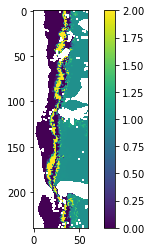

In [41]:

ranks = argsort_output
max_class = ranks == 0
runner_up_class = ranks == 1
POST = ds.PCM_POST.values
runner_up_term = np.multiply(runner_up_class, POST)
max_term = np.multiply(max_class, POST)
i_metric = 1 + np.negative(np.sum(max_term, axis=0)) + np.sum(runner_up_term, axis=0)
plt.imshow(i_metric.T)
plt.colorbar()


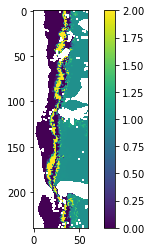

In [42]:
i_metric = np.zeros([np.shape(argsort_output)[1], np.shape(argsort_output)[2]])
runner_up_grid = np.zeros(np.shape(i_metric))
max_grid = np.zeros(np.shape(i_metric))


for i in range(np.shape(argsort_output)[1]):
    for j in range(np.shape(argsort_output)[2]):
        for k in range(np.shape(argsort_output)[0]):
            if argsort_output[k, i, j] == 0:
                max_grid[i, j] = ds.PCM_POST.values[k, i, j]
            elif argsort_output[k, i, j] == 1:
                runner_up_grid[i, j] = ds.PCM_POST.values[k, i, j]

i_metric = 1 - max_grid + runner_up_grid

plt.imshow(i_metric.T)
plt.colorbar()
        

In [43]:
X, sampling_dims = m.preprocessing(ds, features={'THETA': 'THETA', 'SALT': 'SALT'}, dim='Z', action='fit', mask=None)


  fit.1-preprocess.1-mask: 53 ms
[-2.100e+00 -6.700e+00 -1.215e+01 -1.855e+01 -2.625e+01 -3.525e+01
 -4.500e+01 -5.500e+01 -6.500e+01 -7.500e+01 -8.500e+01 -9.500e+01
 -1.050e+02 -1.150e+02 -1.250e+02 -1.350e+02 -1.465e+02 -1.615e+02
 -1.800e+02 -2.000e+02 -2.200e+02 -2.400e+02 -2.600e+02 -2.800e+02
 -3.010e+02 -3.270e+02 -3.610e+02 -4.025e+02 -4.500e+02 -5.000e+02
 -5.515e+02 -6.140e+02 -7.000e+02 -8.000e+02 -9.000e+02 -1.000e+03
 -1.100e+03 -1.225e+03 -1.400e+03 -1.600e+03 -1.800e+03 -2.010e+03
 -2.270e+03 -2.610e+03 -3.000e+03 -3.400e+03 -3.800e+03 -4.200e+03
 -4.600e+03 -5.000e+03 -5.400e+03 -5.800e+03]
  fit.1-preprocess.2-feature_THETA.1-ravel: 31 ms
[-2.100e+00 -6.700e+00 -1.215e+01 -1.855e+01 -2.625e+01 -3.525e+01
 -4.500e+01 -5.500e+01 -6.500e+01 -7.500e+01 -8.500e+01 -9.500e+01
 -1.050e+02 -1.150e+02 -1.250e+02 -1.350e+02 -1.465e+02 -1.615e+02
 -1.800e+02 -2.000e+02 -2.200e+02 -2.400e+02 -2.600e+02 -2.800e+02
 -3.010e+02 -3.270e+02 -3.610e+02 -4.025e+02 -4.500e+02 -5.000e+02


In [44]:
sampling_dims

['YC', 'XC']

In [48]:
x = m.unravel(ds, ['YC', 'XC'], X.values[:, 0])


In [49]:
x

<xarray.DataArray (YC: 60, XC: 240)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [1.59524867, 1.54259629, 1.56006035, ..., 1.52839353, 1.4975691 ,
        1.59311484],
       [1.52068082, 1.50347995,        nan, ..., 1.50866883, 1.52383357,
        1.50518975],
       [1.48088323, 1.51379852, 1.58128906, ..., 1.54223376, 1.60955931,
        1.49253627]])
Coordinates:
  * YC       (YC) float64 -77.98 -77.16 -76.35 -75.53 ... -31.35 -30.53 -29.72
  * XC       (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
    time     datetime64[ns] 2011-08-01T15:12:00

In [52]:
x = x.rename('TEST')

In [54]:
x.attrs['long_name'] = 'Test Test'
x.attrs['features'] = 'Test Test Test'

In [55]:
x

<xarray.DataArray 'TEST' (YC: 60, XC: 240)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [1.59524867, 1.54259629, 1.56006035, ..., 1.52839353, 1.4975691 ,
        1.59311484],
       [1.52068082, 1.50347995,        nan, ..., 1.50866883, 1.52383357,
        1.50518975],
       [1.48088323, 1.51379852, 1.58128906, ..., 1.54223376, 1.60955931,
        1.49253627]])
Coordinates:
  * YC       (YC) float64 -77.98 -77.16 -76.35 -75.53 ... -31.35 -30.53 -29.72
  * XC       (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
    time     datetime64[ns] 2011-08-01T15:12:00
Attributes:
    long_name:  Test Test
    features:   Test Test Test

In [56]:
ds

<xarray.Dataset>
Dimensions:     (XC: 240, YC: 60, Z: 52, pcm_class: 4)
Coordinates:
    time        datetime64[ns] 2011-08-01T15:12:00
  * Z           (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * YC          (YC) float64 -77.98 -77.16 -76.35 ... -31.35 -30.53 -29.72
  * XC          (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
Dimensions without coordinates: pcm_class
Data variables:
    SALT        (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    THETA       (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    PCM_LABELS  (YC, XC) float64 nan nan nan nan nan nan ... 1.0 1.0 1.0 1.0 1.0
    PCM_POST    (pcm_class, YC, XC) float64 nan nan ... 3.086e-282 7.904e-248
    PCM_RANK    (pcm_class, YC, XC) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0

(array([114992., 179035.,  65932.,  46385.,  37301.,  32322.,  26125.,
         22592.,  14151.,   3889.]),
 array([-1.95830749,  0.37586564,  2.71003877,  5.0442119 ,  7.37838503,
         9.71255816, 12.04673129, 14.38090442, 16.71507755, 19.04925068,
        21.38342381]),
 <a list of 10 Patch objects>)

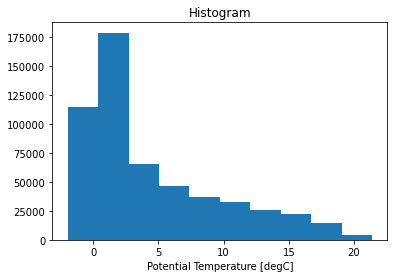

In [57]:
ds.THETA.plot()